<a href="https://colab.research.google.com/github/sttesta3/7506R-1C2024-GRUPO08/blob/santiago/TP2_BayesNaive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Configuración inicial notebook

In [1]:
# General libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelo
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Metricas
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, roc_auc_score

# Entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold


In [2]:
# Configuración token
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Si esta mi token literal. Meh, por ahora no tengo nada muy importante ahi
api_token = {"username":"sttesta3","key":"6041f75a7e294a7d093a3c7b47d47766"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c "20241c-7506tp2"
!unzip 20241c-7506tp2.zip
# Tomado de https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab

 92% 29.0M/31.5M [00:01<00:00, 23.1MB/s]
100% 31.5M/31.5M [00:01<00:00, 19.2MB/s]
Archive:  20241c-7506tp2.zip
  inflating: sample_solution.csv     
  inflating: test.csv                
  inflating: train.csv               


In [3]:
# Carga de data y separación en train-test
ds = pd.read_csv("train.csv")
# Mezclamos las cartas
ds = ds.sample(frac = 1)
# Referencia https://www.geeksforgeeks.org/pandas-how-to-shuffle-a-dataframe-rows/

# Bag of words
# Referencia https://www.kaggle.com/code/vipulgandhi/bag-of-words-model-for-beginners
vectorizer = CountVectorizer()
vectorizer.fit(ds.review_es)
vector = vectorizer.transform(ds.review_es)

# Dummies
ds["sentimiento"] = ds["sentimiento"].map({"positivo":0,"negativo":1})

# División en entrenamiento y test
features = "review_es"
target="sentimiento"

X_train, X_test, Y_train, Y_test = train_test_split(vector,
                                                    ds[target].values,
                                                    test_size=0.3,    #30% 0 conjunto de test
                                                    stratify=ds[target].values) #estratificado para mantener proporcion

### Analisis datos

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 33725 to 38837
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


### Modelo Naive Bayes
#### El modelo a entrenar es un naive bayes. Inicialmente probaremos con alpha=1 ( como se explico en la teórica ) y luego se revisará como performa en

In [ ]:
# Loop de entrenamiento
CANT_FOLDS_MAXIMA = 105
CANT_FOLDS_MINIMA = 2

NBs = []
resultados = []

# Ajuste bruto
for i in range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA + 1,10):
  print("#################",i,"FOLDS #################")
  NBcv = MultinomialNB()
  resultados3 = cross_validate(NBcv,X_train, Y_train, cv=StratifiedKFold(n_splits=i),scoring=make_scorer(f1_score),return_estimator=True)
  metricsCV=resultados3['test_score']
  NBs.append( resultados3['estimator'][np.where(metricsCV==max(metricsCV))[0][0]] )
  resultados.append( resultados3['test_score'][np.where(metricsCV==max(metricsCV))[0][0]] )

resultados_test = [ f1_score(Y_test, modelo.predict(X_test)) for modelo in NBs ]

################# 2 FOLDS #################
################# 12 FOLDS #################
################# 22 FOLDS #################
################# 32 FOLDS #################
################# 42 FOLDS #################
################# 52 FOLDS #################
################# 62 FOLDS #################
################# 72 FOLDS #################
################# 82 FOLDS #################
################# 92 FOLDS #################
################# 102 FOLDS #################


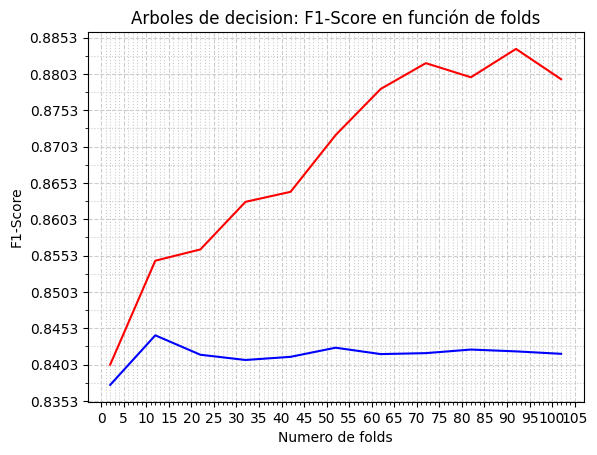

In [ ]:
# Graficos de F1-Score en función de Folds para ajuste vruto
fig = plt.figure()
ax = fig.add_subplot()
x_major_ticks = np.arange(0, CANT_FOLDS_MAXIMA + 1, 5)
x_minor_ticks = np.arange(0, CANT_FOLDS_MAXIMA + 1, 1)
y_major_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0050)
y_minor_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0025)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.grid(which='major', color='#CCCCCC', linestyle='--')

ax.set_xlabel("Numero de folds")
ax.set_ylabel("F1-Score")
ax.set_title("Arboles de decision: F1-Score en función de folds")

plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA + 1,10), resultados, label="F1-Score",color="red")
plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA + 1,10), resultados_test, label="F1-Score",color="blue")

plt.show()

# Referencia utilizada para el gráfico https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels

#### Parecería que entre tres y diez folds esta la cantidad ideal. Utilizaremos treinta debido al leve pico en test entre 20 y 25.
#### De todos modos, parece que aunque el modelo haga un gran overfitting su performance en test se mantiene constante  

In [ ]:
# Loop de entrenamiento
CANT_FOLDS_MAXIMA_FINO = 30

NBs = []
resultados = []

# Ajuste bruto
for i in range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA_FINO + 1):
  print("#################",i,"FOLDS #################")
  NBcv = MultinomialNB()
  resultados3 = cross_validate(NBcv,X_train, Y_train, cv=StratifiedKFold(n_splits=i),scoring=make_scorer(f1_score),return_estimator=True)
  metricsCV=resultados3['test_score']
  NBs.append( resultados3['estimator'][np.where(metricsCV==max(metricsCV))[0][0]] )
  resultados.append( resultados3['test_score'][np.where(metricsCV==max(metricsCV))[0][0]] )

resultados_test = [ f1_score(Y_test, modelo.predict(X_test)) for modelo in NBs ]

################# 2 FOLDS #################
################# 3 FOLDS #################
################# 4 FOLDS #################
################# 5 FOLDS #################
################# 6 FOLDS #################
################# 7 FOLDS #################
################# 8 FOLDS #################
################# 9 FOLDS #################
################# 10 FOLDS #################
################# 11 FOLDS #################
################# 12 FOLDS #################
################# 13 FOLDS #################
################# 14 FOLDS #################
################# 15 FOLDS #################
################# 16 FOLDS #################
################# 17 FOLDS #################
################# 18 FOLDS #################
################# 19 FOLDS #################
################# 20 FOLDS #################
################# 21 FOLDS #################
################# 22 FOLDS #################
################# 23 FOLDS #################
################# 

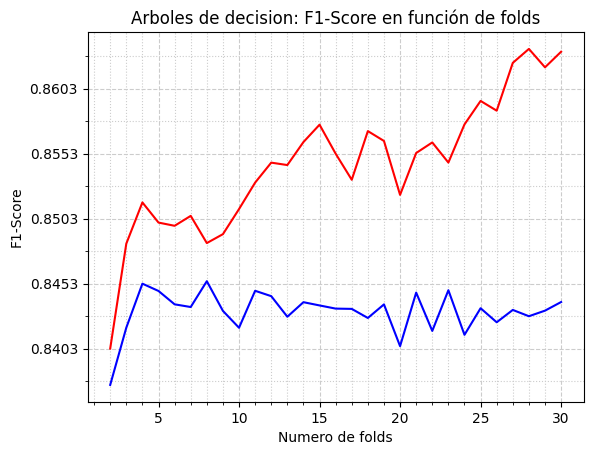

In [ ]:
# Graficos de F1-Score en función de Folds para ajuste vruto
fig = plt.figure()
ax = fig.add_subplot()
x_major_ticks = np.arange(0, CANT_FOLDS_MAXIMA_FINO + 1, 5)
x_minor_ticks = np.arange(0, CANT_FOLDS_MAXIMA_FINO + 1, 1)
y_major_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0050)
y_minor_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0025)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.grid(which='major', color='#CCCCCC', linestyle='--')

ax.set_xlabel("Numero de folds")
ax.set_ylabel("F1-Score")
ax.set_title("Arboles de decision: F1-Score en función de folds")

plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA_FINO + 1), resultados, label="F1-Score",color="red")
plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA_FINO + 1), resultados_test, label="F1-Score",color="blue")

plt.show()

# Referencia utilizada para el gráfico https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels

In [ ]:
print("Indice maximo:",resultados_test.index(max(resultados_test))+CANT_FOLDS_MINIMA)
print("Valor:",round(resultados_test[resultados_test.index(max(resultados_test))],5))

Indice maximo: 8
Valor: 0.84546


##### La cantidad de folds ideal, con una performance muy similar entre entrenamiento y prueba es de ocho folds.

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      7500
           1       0.82      0.88      0.85      7500

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Text(50.722222222222214, 0.5, 'Clasificación')

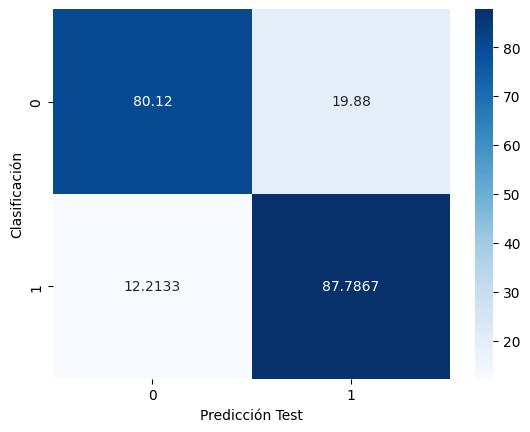

In [ ]:
# EVALUACION
BEST_FOLDS = 8
mejor_performance = NBs[BEST_FOLDS - CANT_FOLDS_MINIMA]
y_pred = mejor_performance.predict(X_test)

print(classification_report(Y_test,y_pred))

cm = confusion_matrix(Y_test,y_pred,normalize='true')*100
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción Test')
plt.ylabel('Clasificación')

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     17500
           1       0.88      0.94      0.91     17500

    accuracy                           0.90     35000
   macro avg       0.91      0.90      0.90     35000
weighted avg       0.91      0.90      0.90     35000



Text(50.722222222222214, 0.5, 'Clasificación')

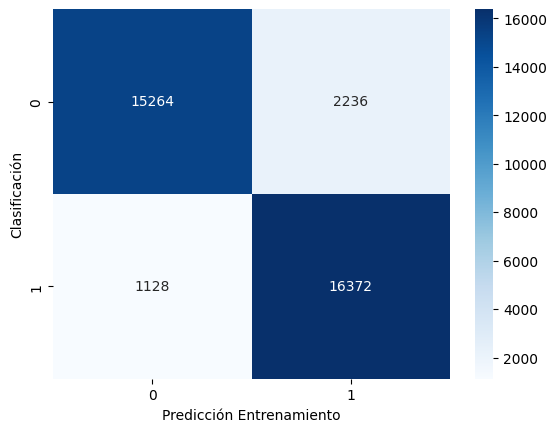

In [ ]:
# EVALUACION CONTRA ENTRENAMIENTO
y_pred_train = mejor_performance.predict(X_train)
print(classification_report(Y_train,y_pred_train))

cm = confusion_matrix(Y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción Entrenamiento')
plt.ylabel('Clasificación')

##### Parecería que es muy bueno!!!! F1-Score = 84
#### Se observa la diferencia de overfit entre train y test por la baja cantidad de error ( en test un 31% y en train un 18% )

In [ ]:
ds_test = pd.read_csv("test.csv")
vector_test = vectorizer.transform(ds_test.review_es)
ds_test['sentimiento'] = mejor_performance.predict(vector_test)
ds_test['sentimiento'] = ds_test['sentimiento'].map({0:"positivo",1:"negativo"})

f = open("solucion.csv", "w")
f.write(ds_test.to_csv(columns=["ID","sentimiento"],index=False) )
f.close()


In [ ]:
print(ds.sentimiento.value_counts())
print(ds_test.sentimiento.value_counts())

sentimiento
1    25000
0    25000
Name: count, dtype: int64
sentimiento
positivo    4394
negativo    4205
Name: count, dtype: int64


In [ ]:
!mv solucion.csv submission.csv

In [9]:
!kaggle competitions submit -c 20241c-7506tp2 -f submission.csv -m "Prediccion con alpha=1"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 806, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 757, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/usr/lib/python3.10/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'


### Modelo Random Forest

In [ ]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1,warm_start=True, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [32,64,128],
               "min_samples_split" : [64,128,256],
               "n_estimators": [25,50,100] }

gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="f1", cv=8, n_jobs=-1)
gs = gs.fit(X_train, Y_train)

print(gs.best_score_)
print(gs.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8133361329960067
{'criterion': 'entropy', 'min_samples_leaf': 32, 'min_samples_split': 256, 'n_estimators': 50}


In [5]:
rf_cv2 = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1,warm_start=True, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [8,16,32],
               "min_samples_split" : [16,32,64],
               "n_estimators": [25,50,100] }

gs2 = GridSearchCV(estimator=rf_cv2, param_grid=param_grid, scoring="f1", cv=8, n_jobs=-1)
gs2 = gs2.fit(X_train, Y_train)

print(gs2.best_score_)
print(gs2.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8389505251425716
{'criterion': 'entropy', 'min_samples_leaf': 8, 'min_samples_split': 64, 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.83      0.86      0.84      7500
           1       0.85      0.83      0.84      7500

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



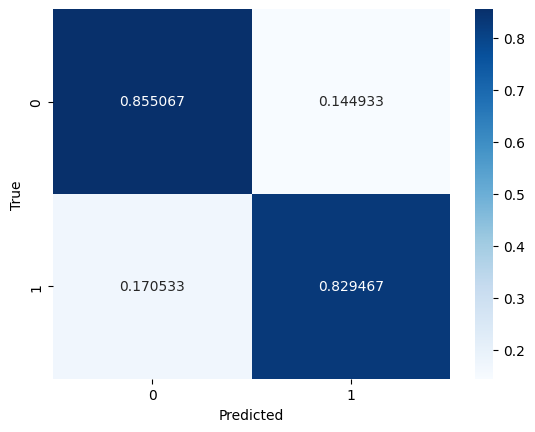

In [7]:
mejor_rf = gs2.best_estimator_
Y_pred_train = mejor_rf.predict(X_train)
Y_pred_test = mejor_rf.predict(X_test)

#Creo matriz de confusión
tabla=confusion_matrix(Y_test,Y_pred_test,normalize="true")

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(Y_test,Y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     17500
           1       0.90      0.88      0.89     17500

    accuracy                           0.89     35000
   macro avg       0.89      0.89      0.89     35000
weighted avg       0.89      0.89      0.89     35000



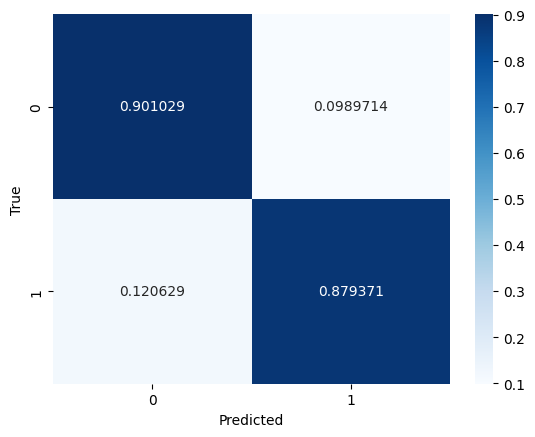

In [8]:
#Creo matriz de confusión
tabla=confusion_matrix(Y_train,Y_pred_train,normalize="true")

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(Y_train,Y_pred_train))

# 5 Folds .83 en test .85 en Train
# 8 Folds igual

In [11]:
ds_test = pd.read_csv("test.csv")
vector_test = vectorizer.transform(ds_test.review_es)
ds_test['sentimiento'] = mejor_rf.predict(vector_test)
ds_test['sentimiento'] = ds_test['sentimiento'].map({0:"positivo",1:"negativo"})

f = open("submission.csv", "w")
f.write(ds_test.to_csv(columns=["ID","sentimiento"],index=False) )
f.close()

!kaggle competitions submit -c 20241c-7506tp2 -f submission.csv -m "Prediccion con random forest optimizado"

100% 126k/126k [00:01<00:00, 102kB/s]
Successfully submitted to 2024-1C  TP-02 - Organización de Datos FIUBA

#### Score: 0.71835